# Introduction to Word Representation

In [1]:
""" Import necessary packages we need. """

import re
import json
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report

from IPython.display import display
%matplotlib inline

In [3]:
""" Simple text cleaning """

# Read stopword list
#with open('stopwords.txt') as f:
#    stopwords = f.readlines()
#stopwords = [w.strip() for w in stopwords]

stopwords = ['the']

# Read dictionary of abbreviation as key and its orginal form as value
#with open('abbreviations.json') as f:
#    abbr_dict = json.load(f)

""" Preprocessing utility for later use. """
def clean_text(text):
    text = str(text)
    # Remove '\n' and '\'
    text = text.lower().replace("\\n", "").replace('\\', '')
    # Replace abbreviation to its orginal form
    #for k, v in abbr_dict.items():
    #    text = text.replace(k, v)
    # Remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # Remove stop words and join the words back into one string separated by space
    text = " ".join([w for w in text.split() if not w in stopwords])
    return text

## Discrete Representation
- Use one-hot vectors in the context of machine learning/deep learning.
    - For example, our vocabulary is: {'dog, 'cat', 'bark', 'meow'}
    - Then each word represents in one-hot will be:
        - vec('dog') : [1, 0, 0, 0]
        - vec('cat') : [0, 1, 0, 0]
        - vec('bark'): [0, 0, 1, 0]
        - vec('meow'): [0, 0, 0, 1]
- Problems: 
    - Hard to measure word similarity.
    - Cannot handle missing words.
    - Hard to compute semantic relationships (e.g. "I am good at NLP" v.s. "I am a NLP expert")
    - Inefficent to compute when vocabulary size is large.

## Distributional Representation

- Motivation: Preserve semantic information while having relatively low dimensionality for machine learning/deep learning. 
- Idea: Distributional hypothesis, "Words that occur in similar contexts (with the same neighboring words), tend to have similar meanings.".
- Two main approaches: count-based model and predictive model.

### Count-based Model
- Idea: Compute the statistics of how often some word co-occurs with its neighbor words in a large text corpus, sometimes further maps these count-statistics down to a small, dense vector for each word.
- Adavantage: Capture co-occurrence statistics of the corpus ("global" information).
- Problem: Sparse, matrix is very large to compute (need a lot of memory).
- Let's see the following simple example. We basically do the following things:
    - Use `CountVectorizer` to build document-term matrix.
    - Build word co-occurence matrix from document-term matrix.
    - Each row/col of word co-occurence matrix is our word distributional representation.
    - Measure the word similarity using cosine similarity.
    - Visualize word vectors using SVD.

Vocabulary: {'dog': 3, 'run': 6, 'cat': 2, 'sleep': 7, 'bark': 0, 'meows': 5, 'bird': 1, 'fly': 4}
Unordered columns: ['dog', 'run', 'cat', 'sleep', 'bark', 'meows', 'bird', 'fly']
Ordered columns: ['bark', 'bird', 'cat', 'dog', 'fly', 'meows', 'run', 'sleep']

Document-Term Matrix:


,bark,bird,cat,dog,fly,meows,run,sleep
the dog run.,0,0,0,1,0,0,1,0
the cat run.,0,0,1,0,0,0,1,0
the dog sleep.,0,0,0,1,0,0,0,1
the cat sleep.,0,0,1,0,0,0,0,1
the dog bark.,1,0,0,1,0,0,0,0
the cat meows.,0,0,1,0,0,1,0,0
the bird fly.,0,1,0,0,1,0,0,0
the bird sleep.,0,1,0,0,0,0,0,1



Word Co-occurence Matrix:


,bark,bird,cat,dog,fly,meows,run,sleep
bark,1,0,0,1,0,0,0,0
bird,0,1,0,0,1,0,0,1
cat,0,0,1,0,0,1,1,1
dog,1,0,0,1,0,0,1,1
fly,0,1,0,0,1,0,0,0
meows,0,0,1,0,0,1,0,0
run,0,0,1,1,0,0,1,0
sleep,0,1,1,1,0,0,0,1


'Word-to-ID dictionary'

{'dog': 3,
 'run': 6,
 'cat': 2,
 'sleep': 7,
 'bark': 0,
 'meows': 5,
 'bird': 1,
 'fly': 4}

'ID-to-Word dictionary'

{3: 'dog',
 6: 'run',
 2: 'cat',
 7: 'sleep',
 0: 'bark',
 5: 'meows',
 1: 'bird',
 4: 'fly'}

dog vector: [1 0 0 1 0 0 1 1]
cat vector: [0 0 1 0 0 1 1 1]
bird vector: [0 1 0 0 1 0 0 1]
bark vector: [1 0 0 1 0 0 0 0]

dog v.s. cat: 0.5
dog v.s. bird: 0.28867513459481287
dog v.s. bark: 0.7071067811865475
cat v.s. bark: 0.0


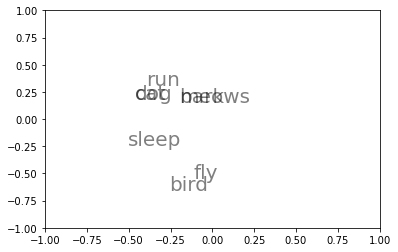

In [4]:
# Assume this is our data.
documents = [
    'the dog run.',
    'the cat run.',
    'the dog sleep.',
    'the cat sleep.',
    'the dog bark.',
    'the cat meows.',
    'the bird fly.',
    'the bird sleep.'
]

# Contruct document-term matrix
vectorizer = CountVectorizer(preprocessor=clean_text, analyzer='word', ngram_range=(1, 1))

# Or... you can try `TfidfVectorizer`
# vectorizer = TfidfVectorizer(preprocessor=clean_text, analyzer='word', ngram_range=(1, 1))

document_term_matrix = vectorizer.fit_transform(documents).toarray()

# Contruct word-occurence matrix from document-term matrix
word_cooccurence_matrix = np.dot(document_term_matrix.T, document_term_matrix)
np.fill_diagonal(word_cooccurence_matrix, 1)

# Print mapping of term and feature index
print('Vocabulary: {}'.format(vectorizer.vocabulary_))

# We need to sort key by its index in order to visualize feature index in correct order.
ordered_columns = []
for col, index in vectorizer.vocabulary_.items():
    ordered_columns.append((col, index))
ordered_columns.sort(key=lambda x: x[1])
ordered_columns = [col for col, index in ordered_columns]

# If you iterate dictionary, it won't preserve the order
unordered_columns = [col for col, index in vectorizer.vocabulary_.items()]

print('Unordered columns: {}'.format(unordered_columns))
print('Ordered columns: {}'.format(ordered_columns))

# Visualize our document-term matrix
print('\nDocument-Term Matrix:')
display(pd.DataFrame(document_term_matrix, index=documents, columns=ordered_columns))
# Visualize our word-occurence matrix
print('\nWord Co-occurence Matrix:')
display(pd.DataFrame(word_cooccurence_matrix, index=ordered_columns, columns=ordered_columns))

word2id = vectorizer.vocabulary_
id2word = {x[1]: x[0] for x in word2id.items()}

display('Word-to-ID dictionary')
display(word2id)
display('ID-to-Word dictionary')
display(id2word)

vector_dog = word_cooccurence_matrix[word2id['dog']]
vector_cat = word_cooccurence_matrix[word2id['cat']]
vector_bird = word_cooccurence_matrix[word2id['bird']]
vector_bark = word_cooccurence_matrix[word2id['bark']]

print('dog vector: {}'.format(vector_dog))
print('cat vector: {}'.format(vector_cat))
print('bird vector: {}'.format(vector_bird))
print('bark vector: {}\n'.format(vector_bark))

print('dog v.s. cat: {}'.format(1 - cosine(vector_dog, vector_cat)))
print('dog v.s. bird: {}'.format(1 - cosine(vector_dog, vector_bird)))
print('dog v.s. bark: {}'.format(1 - cosine(vector_dog, vector_bark)))
print('cat v.s. bark: {}'.format(1 - cosine(vector_cat, vector_bark)))

# Visualize word vectors using SVD.
# Hint: Using TF-IDF will looks better.
fig = plt.figure()
U, sigma, Vh = np.linalg.svd(word_cooccurence_matrix)
ax = fig.add_subplot(111)
ax.axis([-1, 1, -1, 1])
for i in id2word:
    ax.text(U[i, 0], U[i, 1], id2word[i], alpha=0.5, fontsize=20)
plt.show()

## Predictive Model
- Idea: Directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model).
- Word2vec: A neural-based(shallow neural network) efficient model (Widely used nowadays)
- Adavantage: Scanning context windows across the entire corpus needs less memory than count-based model.
- Problem: Need more time to compute.

## Word2vec
- Two different objectives:
    - *Continuous Bag of Words (CBOW)*: Predict target word from context words.
    - *Skip-grams*: Predict context words from target word.
- Two efficient training algorithms: *Negative Sampling* and *Hierarchical Softmax*.
![CBOW-SG](img/cbow-sg.png)
- We only introduce *Skip-grams* and *Negative Sampling* here.

### Skip-gram
- Objective: Given a target word, maximize the probability of the context word (Maximum likelihood estimation). For mathimatical convenience, it's equivalent to **minimizing negative log probability** since product becomes sum.
- Maximizing the objective $J(\theta) = \prod_{t=1}^{T} \prod_{-m \leq j \leq m, j \neq 0} p(w_{t+j} | w_t ; \theta)$ turns to minimizing $J'(\theta) = -\frac{1}{T} \sum_{t=1}^{T} \sum_{-m \leq j \leq m, j \neq 0} \log p(w_{t+j} | w_t ; \theta)$.
- $t$ denotes the index of center word, $m$ denotes window size.
- With probability defined as: $p(o|c) = \frac{exp(u_o^T v_c)}{\sum_{w=1}^W exp(u_w^T v_c)}$, where $o$ denotes output word index, $c$ denotes center(target) word index and $W$ is number of vocabulary.
- Dot product $u^T v = u \cdot v$: Bigger if $u$ and $v$ is similar!
- Softmax $\frac{exp(z_i)}{\sum_j exp(z_j)}$: $exp(z_i)$ yields positive numbers; dividing $\sum_j exp(z_j)$ normalizes the output to probability distribution.
- Compute gradients of $\theta$ w.r.t $v_c$ and update $\theta$ by sochastic gradient descent: $\theta^{new} = \theta^{old} - \alpha\frac{\partial}{\partial\theta^{old}}J'(\theta)$, where $\alpha$ is *learning rate*.
- Problem of softmax function: For each training step, we need to do the gigantic sum ($\sum_{w=1}^W exp(u_w^T v_c)$ term in softmax), which is very computationally expensive.
![SG](img/sg.png)

### Negative Sampling (Simplified Version of Noise Contrastive Estimation; NCE)
- Idea: Instead of doing giganic sum in softmax function, we turn our previous objective into **maximizing probability of true pair (center word paired with word in its context window)** and **minimizing noise pairs (center word paired with a random word)**
- New objective is defined as: $\log\sigma(u_o^T v_c) + \sum_{i=1}^k \mathbb{E}_{j~P(w)}[log \sigma(-u_j^T v_c)]$, where there are $k$ negative samples for each data sample. $k$ in the range 5–20 are useful for small training datasets, while for large datasets the $k$ can be as
small as 2–5.
- $\sigma(x) = \frac{1}{1 + e^{-x}}$ maps $x$ to 0~1, which mimics the measurement of probability.

## More popular word/sentence embeddings to use:
- [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
- [FastText by Facebook](https://github.com/facebookresearch/fastText)
- [Paragraph2vec/Doc2vec (Extenstion of word2vec)](https://radimrehurek.com/gensim/models/doc2vec.html)
- [Skip-Thought Vectors](https://github.com/ryankiros/skip-thoughts)
- [Sense2Vec](https://github.com/explosion/sense2vec)
- https://github.com/Hironsan/awesome-embedding-models

## Relative papers:
- [Don’t count, predict! A systematic comparison ofcontext-counting vs. context-predicting semantic vectors](http://clic.cimec.unitn.it/marco/publications/acl2014/baroni-etal-countpredict-acl2014.pdf)
- [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
- [Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [word2vec Explained: Deriving Mikolov et al.’s Negative-Sampling Word-Embedding Method](https://arxiv.org/pdf/1402.3722v1.pdf)
- [Neural Word Embedding as Implicit Matrix Factorization](https://arxiv.org/pdf/1402.3722v1.pdf)
- [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)
- [Improving Distributional Similarity with Lessons Learned from Word Embeddings](http://www.aclweb.org/anthology/Q15-1016)
- [Evaluation methods for unsupervised word embeddings](http://www.aclweb.org/anthology/D15-1036)

## Reference:
The above content is covered in more detail on [Standford Cs224d Deep learning for NLP](http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture2.pdf)

In [7]:
# Assume this is our data.
documents = [
    'the dog run.',
    'the cat run.',
    'the dog sleep.',
    'the cat sleep.',
    'the dog bark.',
    'the cat meows.',
    'the bird fly.',
    'the bird sleep.'
]

# Clean text.
documents = [clean_text(doc) for doc in documents]
# Prepare input format for training word2vec.
documents = [doc.split() for doc in documents]
print('Input for word2vec:')
display(documents)

Input for word2vec:


[['dog', 'run'],
 ['cat', 'run'],
 ['dog', 'sleep'],
 ['cat', 'sleep'],
 ['dog', 'bark'],
 ['cat', 'meows'],
 ['bird', 'fly'],
 ['bird', 'sleep']]

In [10]:
# Start to train word2vec.
"""
    @param `sg`: sg defines the training algorithm (skip-gram). By default (sg=0), CBOW is used. Otherwise (sg=1).
    @param `size`: number of dimension of the feature vectors.
    @param `window`: maximum distance between the current and predicted word within a sentence.
    @param `min_count`: ignore all words with total frequency lower than this.
    @param `negative`: Specifies how many “noise words” should be drawn (usually between 5-20). (Default=5).
                       5–20 are useful for small training datasets, while for large datasets the k can be as
                       small as 2–5
    More detail on: https://radimrehurek.com/gensim/models/word2vec.html
"""
print('Training word2vec ...\n')
model_w2v = gensim.models.Word2Vec(documents, sg=1, vector_size=2, window=3, min_count=1, negative=5)
#model_w2v = gensim.models.Word2Vec(documents, sg=1, window=3, min_count=1, negative=5)
print('Attributes in word2vec model:')
display(vars(model_w2v.wv))

Training word2vec ...

Attributes in word2vec model:


{'vector_size': 2,
 'index_to_key': ['sleep',
  'cat',
  'dog',
  'bird',
  'run',
  'fly',
  'meows',
  'bark'],
 'next_index': 0,
 'key_to_index': {'sleep': 0,
  'cat': 1,
  'dog': 2,
  'bird': 3,
  'run': 4,
  'fly': 5,
  'meows': 6,
  'bark': 7},
 'vectors': array([[-0.02681136,  0.01182151],
        [ 0.25516748,  0.45046365],
        [-0.4651475 , -0.35584044],
        [ 0.32294357,  0.4486494 ],
        [-0.2507714 , -0.18816864],
        [ 0.36902523, -0.07667363],
        [-0.22683072,  0.32770252],
        [-0.24300802, -0.09080088]], dtype=float32),
 'norms': None,
 'expandos': {'count': array([3, 3, 3, 2, 2, 1, 1, 1]),
  'sample_int': array([336566555, 336566555, 336566555, 418513291, 418513291, 611994641,
         611994641, 611994641], dtype=uint32)},
 'mapfile_path': None,
 'vectors_lockf': array([1.], dtype=float32)}

In [19]:
print(type(model_w2v))

<class 'gensim.models.word2vec.Word2Vec'>


# Visualize word vectors.
min_x = np.min(model_w2v.wv.vectors[:, 0]) - 0.1
max_x = np.max(model_w2v.wv.vectors[:, 0]) + 0.1
min_y = np.min(model_w2v.wv.vectors[:, 1]) - 0.1
max_y = np.max(model_w2v.wv.vectors[:, 1]) + 0.1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis([min_x, max_x, min_y, max_y])
for word in model_w2v.wv.index_to_key:
    vec = model_w2v.wv[word]
    ax.text(vec[0], vec[1], word, alpha=0.5, fontsize=20)
plt.show()

In [17]:
# You can use `most_similar()` to explore the top-5 similar words.
# Cosine similarity has a range of [-1, 1]
# You could interpret negative scores as "opposite meaning".
print('Most similar word to "dog":')
display(model_w2v.wv.most_similar('dog', topn=5))

print('Most similar word to "cat":')
display(model_w2v.wv.most_similar('cat', topn=5))

print('Most similar word to "bird":')
display(model_w2v.wv.most_similar('bird', topn=5))

Most similar word to "dog":


[('run', 0.9999567270278931),
 ('bark', 0.9566723704338074),
 ('sleep', 0.4816076159477234),
 ('meows', -0.04755614697933197),
 ('fly', -0.6540317535400391)]

Most similar word to "cat":


[('bird', 0.9941185712814331),
 ('meows', 0.4349167048931122),
 ('fly', 0.3055635690689087),
 ('sleep', -0.09994927793741226),
 ('bark', -0.7662464380264282)]

Most similar word to "bird":


[('cat', 0.9941185712814331),
 ('fly', 0.40688464045524597),
 ('meows', 0.3348395824432373),
 ('sleep', -0.20711712539196014),
 ('bark', -0.8313261866569519)]